**目标：根据历史数据，预测当天股票最高价**

**1. 改为用 30 天预测 7 天的股价**  
**2. 测试只有前 30 天的数据，预测后面所有的数据**

## 模块导入

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

## 数据读取

### 原始数据获取

### 数据预处理

In [7]:
df = pd.read_csv('sh.csv', index_col=0)
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,code,open,close,high,low,vol,amount,p_change
2005-01-04,300,994.76,982.79,994.76,980.65,74128.0,4.431976e+09,NaN
2005-01-05,300,981.57,992.56,997.32,979.87,71191.0,4.529207e+09,0.99
2005-01-06,300,993.33,983.17,993.78,980.33,62880.0,3.921015e+09,-0.95
2005-01-07,300,983.04,983.95,995.71,979.81,72986.0,4.737468e+09,0.08
2005-01-10,300,983.76,993.87,993.95,979.78,57916.0,3.762931e+09,1.01


In [9]:
def getData(df, column, train_end=-300, days_before=30, days_pred=7, return_all=True, generate_index=False):
    series = df[column].copy()
    
    # 创建训练集
    data = pd.DataFrame()
    
    # 准备天数
    for i in range(days_before):
        # 最后的 -days_before - days_pred 天只是用于预测值，预留出来
        data['b%d' % i] = series.tolist()[i: -days_before - days_pred + i]
    
    # 预测天数
    for i in range(days_pred):
        data['y%d' % i] = series.tolist()[days_before + i: - days_pred + i]
        
    # 是否生成 index
    if generate_index:
        data.index = series.index[days_before:]
        
    train_data, val_data, test_data = data[:train_end-300], data[train_end-300:train_end], data[train_end:]
                
    if return_all:
        return train_data, val_data, test_data, series, df.index.tolist()
    
    return train_data, val_data, test_data

## 创建 LSTM 层

In [10]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=128,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(128, 1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -7:, :])          # 取最后一天作为输出
        
        return out

In [11]:
class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-7].float(), data[:, -7:].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

## 超参数

In [12]:
LR = 0.0001
EPOCH = 1000
TRAIN_END=-300
DAYS_BEFORE=30
DAYS_PRED=7

## 模型训练

### 获取数据
- 训练模型仍然使用 minibatch 的思路
- 注意，模型必须要先把数据标准化，不然损失会很难降低下来。

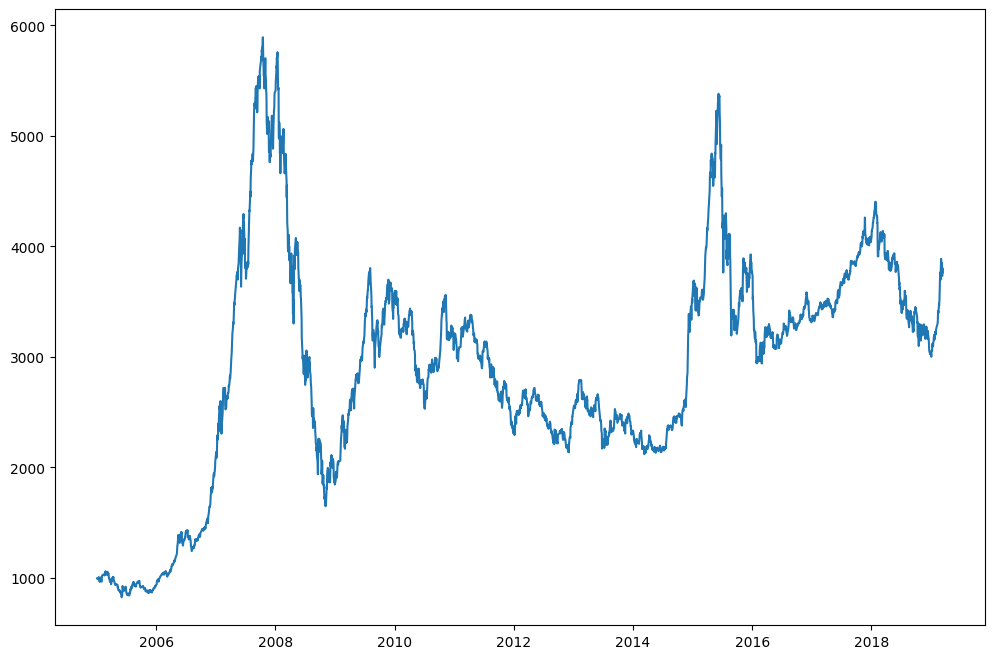

In [13]:
# 数据集建立
train_data, val_data, test_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, days_pred=DAYS_PRED, train_end=TRAIN_END)

# 获取所有原始数据
all_series_test1 = np.array(all_series.copy().tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series_test1, label='real-data')

# 归一化，便与训练  股票数据集 上证指数
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

val_data_numpy = np.array(val_data)
val_data_numpy = (val_data_numpy - train_mean) / train_std
val_data_tensor = torch.Tensor(val_data_numpy)

test_data_numpy = np.array(train_data)
test_data_numpy = (test_data_numpy - train_mean) / train_std
test_data_tensor = torch.Tensor(test_data_numpy)

# 创建 dataloader
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

val_set = TrainSet(val_data_tensor)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)

In [14]:
for tx, ty in train_loader:
    print(tx.shape)
    print(ty.shape)

torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([256, 30])
torch.Size([256, 7])
torch.Size([251, 30])
torch.Size([251, 7])


## 模型训练部分

这个部分如果是不想要训练的话（比如已经训练好了模型），替换为 rnn = torch.load('rnn.pkl') （记得把原来的注释掉）

In [15]:
rnn = LSTM()

if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

best_loss = 1000


if not os.path.exists('weights'):
    os.mkdir('weights')    

for step in range(EPOCH):
    for tx, ty in train_loader:
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda() 
        
        output = rnn(torch.unsqueeze(tx, dim=2))             
        loss = loss_func(torch.squeeze(output), ty)        
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
        
        print('epoch : %d  ' % step, 'train_loss : %.4f' % loss.cpu().item())
        
    with torch.no_grad():
        for tx, ty in val_loader:
            if torch.cuda.is_available():
                tx = tx.cuda()
                ty = ty.cuda() 
        
            output = rnn(torch.unsqueeze(tx, dim=2))             
            loss = loss_func(torch.squeeze(output), ty)
        
            print('epoch : %d  ' % step, 'val_loss : %.4f' % loss.cpu().item())
        
        if loss.cpu().item() < best_loss:
            best_loss = loss.cpu().item()
            torch.save(rnn, 'weights/rnn.pkl'.format(loss.cpu().item()))
            print('new model saved at epoch {} with val_loss {}'.format(step, best_loss))

epoch : 0   train_loss : 0.9402
epoch : 0   train_loss : 0.9170
epoch : 0   train_loss : 0.8669
epoch : 0   train_loss : 0.9846
epoch : 0   train_loss : 0.9174
epoch : 0   train_loss : 1.1233
epoch : 0   train_loss : 1.1148
epoch : 0   train_loss : 1.1094
epoch : 0   train_loss : 0.9396
epoch : 0   train_loss : 0.7964
epoch : 0   train_loss : 0.9295
epoch : 0   val_loss : 0.7317
epoch : 0   val_loss : 0.7428
new model saved at epoch 0 with val_loss 0.7427898049354553
epoch : 1   train_loss : 1.0797
epoch : 1   train_loss : 0.8063
epoch : 1   train_loss : 0.9910
epoch : 1   train_loss : 0.9699
epoch : 1   train_loss : 0.9262
epoch : 1   train_loss : 0.8678
epoch : 1   train_loss : 0.8918
epoch : 1   train_loss : 1.1498
epoch : 1   train_loss : 0.9219
epoch : 1   train_loss : 0.8250
epoch : 1   train_loss : 0.8509
epoch : 1   val_loss : 0.7143
epoch : 1   val_loss : 0.6449
new model saved at epoch 1 with val_loss 0.6448795199394226
epoch : 2   train_loss : 0.9833
epoch : 2   train_loss :

epoch : 19   train_loss : 0.0468
epoch : 19   train_loss : 0.0424
epoch : 19   train_loss : 0.0452
epoch : 19   val_loss : 0.0072
epoch : 19   val_loss : 0.0074
epoch : 20   train_loss : 0.0469
epoch : 20   train_loss : 0.0451
epoch : 20   train_loss : 0.0488
epoch : 20   train_loss : 0.0602
epoch : 20   train_loss : 0.0456
epoch : 20   train_loss : 0.0585
epoch : 20   train_loss : 0.0376
epoch : 20   train_loss : 0.0375
epoch : 20   train_loss : 0.0587
epoch : 20   train_loss : 0.0465
epoch : 20   train_loss : 0.0494
epoch : 20   val_loss : 0.0088
epoch : 20   val_loss : 0.0086
epoch : 21   train_loss : 0.0499
epoch : 21   train_loss : 0.0434
epoch : 21   train_loss : 0.0538
epoch : 21   train_loss : 0.0466
epoch : 21   train_loss : 0.0485
epoch : 21   train_loss : 0.0428
epoch : 21   train_loss : 0.0459
epoch : 21   train_loss : 0.0458
epoch : 21   train_loss : 0.0487
epoch : 21   train_loss : 0.0465
epoch : 21   train_loss : 0.0568
epoch : 21   val_loss : 0.0065
epoch : 21   val_los

epoch : 41   train_loss : 0.0374
epoch : 41   train_loss : 0.0374
epoch : 41   train_loss : 0.0482
epoch : 41   train_loss : 0.0370
epoch : 41   train_loss : 0.0403
epoch : 41   train_loss : 0.0347
epoch : 41   train_loss : 0.0382
epoch : 41   train_loss : 0.0357
epoch : 41   train_loss : 0.0367
epoch : 41   train_loss : 0.0464
epoch : 41   val_loss : 0.0056
epoch : 41   val_loss : 0.0058
epoch : 42   train_loss : 0.0403
epoch : 42   train_loss : 0.0300
epoch : 42   train_loss : 0.0345
epoch : 42   train_loss : 0.0473
epoch : 42   train_loss : 0.0423
epoch : 42   train_loss : 0.0351
epoch : 42   train_loss : 0.0297
epoch : 42   train_loss : 0.0395
epoch : 42   train_loss : 0.0345
epoch : 42   train_loss : 0.0489
epoch : 42   train_loss : 0.0371
epoch : 42   val_loss : 0.0070
epoch : 42   val_loss : 0.0065
epoch : 43   train_loss : 0.0401
epoch : 43   train_loss : 0.0417
epoch : 43   train_loss : 0.0314
epoch : 43   train_loss : 0.0390
epoch : 43   train_loss : 0.0367
epoch : 43   train

epoch : 63   train_loss : 0.0273
epoch : 63   train_loss : 0.0333
epoch : 63   train_loss : 0.0321
epoch : 63   train_loss : 0.0297
epoch : 63   train_loss : 0.0410
epoch : 63   train_loss : 0.0323
epoch : 63   train_loss : 0.0296
epoch : 63   train_loss : 0.0302
epoch : 63   train_loss : 0.0352
epoch : 63   train_loss : 0.0302
epoch : 63   val_loss : 0.0054
epoch : 63   val_loss : 0.0061
epoch : 64   train_loss : 0.0357
epoch : 64   train_loss : 0.0359
epoch : 64   train_loss : 0.0260
epoch : 64   train_loss : 0.0311
epoch : 64   train_loss : 0.0341
epoch : 64   train_loss : 0.0351
epoch : 64   train_loss : 0.0324
epoch : 64   train_loss : 0.0293
epoch : 64   train_loss : 0.0308
epoch : 64   train_loss : 0.0285
epoch : 64   train_loss : 0.0333
epoch : 64   val_loss : 0.0050
epoch : 64   val_loss : 0.0048
epoch : 65   train_loss : 0.0354
epoch : 65   train_loss : 0.0295
epoch : 65   train_loss : 0.0319
epoch : 65   train_loss : 0.0362
epoch : 65   train_loss : 0.0340
epoch : 65   train

epoch : 83   train_loss : 0.0283
epoch : 83   train_loss : 0.0326
epoch : 83   train_loss : 0.0337
epoch : 83   train_loss : 0.0268
epoch : 83   train_loss : 0.0317
epoch : 83   train_loss : 0.0241
epoch : 83   train_loss : 0.0343
epoch : 83   train_loss : 0.0283
epoch : 83   train_loss : 0.0350
epoch : 83   train_loss : 0.0255
epoch : 83   train_loss : 0.0318
epoch : 83   val_loss : 0.0055
epoch : 83   val_loss : 0.0054
epoch : 84   train_loss : 0.0340
epoch : 84   train_loss : 0.0311
epoch : 84   train_loss : 0.0277
epoch : 84   train_loss : 0.0278
epoch : 84   train_loss : 0.0286
epoch : 84   train_loss : 0.0290
epoch : 84   train_loss : 0.0331
epoch : 84   train_loss : 0.0336
epoch : 84   train_loss : 0.0281
epoch : 84   train_loss : 0.0336
epoch : 84   train_loss : 0.0256
epoch : 84   val_loss : 0.0059
epoch : 84   val_loss : 0.0056
epoch : 85   train_loss : 0.0267
epoch : 85   train_loss : 0.0283
epoch : 85   train_loss : 0.0316
epoch : 85   train_loss : 0.0263
epoch : 85   train

epoch : 104   val_loss : 0.0057
epoch : 104   val_loss : 0.0055
epoch : 105   train_loss : 0.0370
epoch : 105   train_loss : 0.0277
epoch : 105   train_loss : 0.0287
epoch : 105   train_loss : 0.0282
epoch : 105   train_loss : 0.0272
epoch : 105   train_loss : 0.0289
epoch : 105   train_loss : 0.0312
epoch : 105   train_loss : 0.0234
epoch : 105   train_loss : 0.0325
epoch : 105   train_loss : 0.0295
epoch : 105   train_loss : 0.0281
epoch : 105   val_loss : 0.0045
epoch : 105   val_loss : 0.0055
epoch : 106   train_loss : 0.0228
epoch : 106   train_loss : 0.0245
epoch : 106   train_loss : 0.0299
epoch : 106   train_loss : 0.0368
epoch : 106   train_loss : 0.0303
epoch : 106   train_loss : 0.0320
epoch : 106   train_loss : 0.0279
epoch : 106   train_loss : 0.0318
epoch : 106   train_loss : 0.0274
epoch : 106   train_loss : 0.0322
epoch : 106   train_loss : 0.0268
epoch : 106   val_loss : 0.0062
epoch : 106   val_loss : 0.0063
epoch : 107   train_loss : 0.0316
epoch : 107   train_loss :

epoch : 126   train_loss : 0.0283
epoch : 126   train_loss : 0.0285
epoch : 126   train_loss : 0.0232
epoch : 126   train_loss : 0.0306
epoch : 126   val_loss : 0.0049
epoch : 126   val_loss : 0.0047
epoch : 127   train_loss : 0.0382
epoch : 127   train_loss : 0.0261
epoch : 127   train_loss : 0.0259
epoch : 127   train_loss : 0.0270
epoch : 127   train_loss : 0.0274
epoch : 127   train_loss : 0.0327
epoch : 127   train_loss : 0.0289
epoch : 127   train_loss : 0.0279
epoch : 127   train_loss : 0.0258
epoch : 127   train_loss : 0.0249
epoch : 127   train_loss : 0.0279
epoch : 127   val_loss : 0.0043
epoch : 127   val_loss : 0.0055
epoch : 128   train_loss : 0.0301
epoch : 128   train_loss : 0.0307
epoch : 128   train_loss : 0.0290
epoch : 128   train_loss : 0.0310
epoch : 128   train_loss : 0.0277
epoch : 128   train_loss : 0.0278
epoch : 128   train_loss : 0.0269
epoch : 128   train_loss : 0.0282
epoch : 128   train_loss : 0.0302
epoch : 128   train_loss : 0.0270
epoch : 128   train_lo

epoch : 148   train_loss : 0.0259
epoch : 148   train_loss : 0.0328
epoch : 148   train_loss : 0.0326
epoch : 148   train_loss : 0.0261
epoch : 148   train_loss : 0.0244
epoch : 148   train_loss : 0.0277
epoch : 148   train_loss : 0.0211
epoch : 148   train_loss : 0.0271
epoch : 148   train_loss : 0.0285
epoch : 148   train_loss : 0.0243
epoch : 148   val_loss : 0.0045
epoch : 148   val_loss : 0.0043
epoch : 149   train_loss : 0.0265
epoch : 149   train_loss : 0.0294
epoch : 149   train_loss : 0.0265
epoch : 149   train_loss : 0.0313
epoch : 149   train_loss : 0.0246
epoch : 149   train_loss : 0.0266
epoch : 149   train_loss : 0.0307
epoch : 149   train_loss : 0.0269
epoch : 149   train_loss : 0.0252
epoch : 149   train_loss : 0.0302
epoch : 149   train_loss : 0.0255
epoch : 149   val_loss : 0.0048
epoch : 149   val_loss : 0.0049
epoch : 150   train_loss : 0.0269
epoch : 150   train_loss : 0.0303
epoch : 150   train_loss : 0.0270
epoch : 150   train_loss : 0.0287
epoch : 150   train_lo

epoch : 169   train_loss : 0.0320
epoch : 169   train_loss : 0.0270
epoch : 169   train_loss : 0.0290
epoch : 169   train_loss : 0.0306
epoch : 169   val_loss : 0.0057
epoch : 169   val_loss : 0.0046
epoch : 170   train_loss : 0.0305
epoch : 170   train_loss : 0.0261
epoch : 170   train_loss : 0.0225
epoch : 170   train_loss : 0.0285
epoch : 170   train_loss : 0.0290
epoch : 170   train_loss : 0.0346
epoch : 170   train_loss : 0.0264
epoch : 170   train_loss : 0.0290
epoch : 170   train_loss : 0.0247
epoch : 170   train_loss : 0.0235
epoch : 170   train_loss : 0.0298
epoch : 170   val_loss : 0.0044
epoch : 170   val_loss : 0.0047
epoch : 171   train_loss : 0.0302
epoch : 171   train_loss : 0.0238
epoch : 171   train_loss : 0.0327
epoch : 171   train_loss : 0.0255
epoch : 171   train_loss : 0.0243
epoch : 171   train_loss : 0.0259
epoch : 171   train_loss : 0.0282
epoch : 171   train_loss : 0.0254
epoch : 171   train_loss : 0.0258
epoch : 171   train_loss : 0.0307
epoch : 171   train_lo

epoch : 191   train_loss : 0.0290
epoch : 191   train_loss : 0.0215
epoch : 191   train_loss : 0.0235
epoch : 191   train_loss : 0.0266
epoch : 191   train_loss : 0.0236
epoch : 191   train_loss : 0.0215
epoch : 191   train_loss : 0.0312
epoch : 191   train_loss : 0.0312
epoch : 191   train_loss : 0.0280
epoch : 191   train_loss : 0.0257
epoch : 191   train_loss : 0.0284
epoch : 191   val_loss : 0.0050
epoch : 191   val_loss : 0.0042
epoch : 192   train_loss : 0.0290
epoch : 192   train_loss : 0.0281
epoch : 192   train_loss : 0.0233
epoch : 192   train_loss : 0.0290
epoch : 192   train_loss : 0.0245
epoch : 192   train_loss : 0.0274
epoch : 192   train_loss : 0.0225
epoch : 192   train_loss : 0.0281
epoch : 192   train_loss : 0.0245
epoch : 192   train_loss : 0.0278
epoch : 192   train_loss : 0.0252
epoch : 192   val_loss : 0.0050
epoch : 192   val_loss : 0.0053
epoch : 193   train_loss : 0.0265
epoch : 193   train_loss : 0.0217
epoch : 193   train_loss : 0.0253
epoch : 193   train_lo

epoch : 212   train_loss : 0.0306
epoch : 212   train_loss : 0.0261
epoch : 212   val_loss : 0.0058
epoch : 212   val_loss : 0.0060
epoch : 213   train_loss : 0.0249
epoch : 213   train_loss : 0.0286
epoch : 213   train_loss : 0.0275
epoch : 213   train_loss : 0.0264
epoch : 213   train_loss : 0.0278
epoch : 213   train_loss : 0.0238
epoch : 213   train_loss : 0.0275
epoch : 213   train_loss : 0.0254
epoch : 213   train_loss : 0.0184
epoch : 213   train_loss : 0.0272
epoch : 213   train_loss : 0.0291
epoch : 213   val_loss : 0.0072
epoch : 213   val_loss : 0.0081
epoch : 214   train_loss : 0.0264
epoch : 214   train_loss : 0.0243
epoch : 214   train_loss : 0.0288
epoch : 214   train_loss : 0.0298
epoch : 214   train_loss : 0.0289
epoch : 214   train_loss : 0.0228
epoch : 214   train_loss : 0.0256
epoch : 214   train_loss : 0.0274
epoch : 214   train_loss : 0.0230
epoch : 214   train_loss : 0.0251
epoch : 214   train_loss : 0.0213
epoch : 214   val_loss : 0.0048
epoch : 214   val_loss :

epoch : 233   train_loss : 0.0271
epoch : 233   train_loss : 0.0252
epoch : 233   train_loss : 0.0243
epoch : 233   train_loss : 0.0231
epoch : 233   train_loss : 0.0234
epoch : 233   train_loss : 0.0269
epoch : 233   train_loss : 0.0281
epoch : 233   train_loss : 0.0239
epoch : 233   train_loss : 0.0297
epoch : 233   val_loss : 0.0046
epoch : 233   val_loss : 0.0038
epoch : 234   train_loss : 0.0235
epoch : 234   train_loss : 0.0256
epoch : 234   train_loss : 0.0264
epoch : 234   train_loss : 0.0203
epoch : 234   train_loss : 0.0301
epoch : 234   train_loss : 0.0243
epoch : 234   train_loss : 0.0228
epoch : 234   train_loss : 0.0283
epoch : 234   train_loss : 0.0263
epoch : 234   train_loss : 0.0231
epoch : 234   train_loss : 0.0286
epoch : 234   val_loss : 0.0048
epoch : 234   val_loss : 0.0035
epoch : 235   train_loss : 0.0273
epoch : 235   train_loss : 0.0286
epoch : 235   train_loss : 0.0262
epoch : 235   train_loss : 0.0244
epoch : 235   train_loss : 0.0299
epoch : 235   train_lo

epoch : 254   train_loss : 0.0245
epoch : 254   train_loss : 0.0282
epoch : 254   train_loss : 0.0226
epoch : 254   train_loss : 0.0246
epoch : 254   train_loss : 0.0269
epoch : 254   train_loss : 0.0215
epoch : 254   val_loss : 0.0062
epoch : 254   val_loss : 0.0063
epoch : 255   train_loss : 0.0255
epoch : 255   train_loss : 0.0267
epoch : 255   train_loss : 0.0248
epoch : 255   train_loss : 0.0256
epoch : 255   train_loss : 0.0191
epoch : 255   train_loss : 0.0212
epoch : 255   train_loss : 0.0253
epoch : 255   train_loss : 0.0291
epoch : 255   train_loss : 0.0253
epoch : 255   train_loss : 0.0293
epoch : 255   train_loss : 0.0243
epoch : 255   val_loss : 0.0069
epoch : 255   val_loss : 0.0067
epoch : 256   train_loss : 0.0234
epoch : 256   train_loss : 0.0270
epoch : 256   train_loss : 0.0283
epoch : 256   train_loss : 0.0202
epoch : 256   train_loss : 0.0293
epoch : 256   train_loss : 0.0282
epoch : 256   train_loss : 0.0244
epoch : 256   train_loss : 0.0223
epoch : 256   train_lo

epoch : 275   val_loss : 0.0046
epoch : 275   val_loss : 0.0050
epoch : 276   train_loss : 0.0243
epoch : 276   train_loss : 0.0239
epoch : 276   train_loss : 0.0255
epoch : 276   train_loss : 0.0214
epoch : 276   train_loss : 0.0231
epoch : 276   train_loss : 0.0209
epoch : 276   train_loss : 0.0250
epoch : 276   train_loss : 0.0275
epoch : 276   train_loss : 0.0334
epoch : 276   train_loss : 0.0222
epoch : 276   train_loss : 0.0212
epoch : 276   val_loss : 0.0045
epoch : 276   val_loss : 0.0036
epoch : 277   train_loss : 0.0231
epoch : 277   train_loss : 0.0235
epoch : 277   train_loss : 0.0240
epoch : 277   train_loss : 0.0246
epoch : 277   train_loss : 0.0269
epoch : 277   train_loss : 0.0261
epoch : 277   train_loss : 0.0240
epoch : 277   train_loss : 0.0225
epoch : 277   train_loss : 0.0220
epoch : 277   train_loss : 0.0268
epoch : 277   train_loss : 0.0275
epoch : 277   val_loss : 0.0042
epoch : 277   val_loss : 0.0032
epoch : 278   train_loss : 0.0221
epoch : 278   train_loss :

epoch : 297   train_loss : 0.0205
epoch : 297   train_loss : 0.0220
epoch : 297   train_loss : 0.0291
epoch : 297   train_loss : 0.0267
epoch : 297   train_loss : 0.0234
epoch : 297   train_loss : 0.0191
epoch : 297   train_loss : 0.0222
epoch : 297   train_loss : 0.0208
epoch : 297   train_loss : 0.0287
epoch : 297   val_loss : 0.0043
epoch : 297   val_loss : 0.0042
epoch : 298   train_loss : 0.0229
epoch : 298   train_loss : 0.0255
epoch : 298   train_loss : 0.0246
epoch : 298   train_loss : 0.0264
epoch : 298   train_loss : 0.0237
epoch : 298   train_loss : 0.0222
epoch : 298   train_loss : 0.0193
epoch : 298   train_loss : 0.0251
epoch : 298   train_loss : 0.0246
epoch : 298   train_loss : 0.0244
epoch : 298   train_loss : 0.0244
epoch : 298   val_loss : 0.0044
epoch : 298   val_loss : 0.0045
epoch : 299   train_loss : 0.0226
epoch : 299   train_loss : 0.0231
epoch : 299   train_loss : 0.0225
epoch : 299   train_loss : 0.0253
epoch : 299   train_loss : 0.0229
epoch : 299   train_lo

epoch : 317   train_loss : 0.0242
epoch : 317   train_loss : 0.0265
epoch : 317   val_loss : 0.0048
epoch : 317   val_loss : 0.0037
epoch : 318   train_loss : 0.0264
epoch : 318   train_loss : 0.0233
epoch : 318   train_loss : 0.0224
epoch : 318   train_loss : 0.0312
epoch : 318   train_loss : 0.0201
epoch : 318   train_loss : 0.0223
epoch : 318   train_loss : 0.0224
epoch : 318   train_loss : 0.0234
epoch : 318   train_loss : 0.0224
epoch : 318   train_loss : 0.0225
epoch : 318   train_loss : 0.0223
epoch : 318   val_loss : 0.0041
epoch : 318   val_loss : 0.0035
epoch : 319   train_loss : 0.0229
epoch : 319   train_loss : 0.0245
epoch : 319   train_loss : 0.0185
epoch : 319   train_loss : 0.0298
epoch : 319   train_loss : 0.0271
epoch : 319   train_loss : 0.0213
epoch : 319   train_loss : 0.0257
epoch : 319   train_loss : 0.0227
epoch : 319   train_loss : 0.0210
epoch : 319   train_loss : 0.0240
epoch : 319   train_loss : 0.0244
epoch : 319   val_loss : 0.0047
epoch : 319   val_loss :

epoch : 339   train_loss : 0.0260
epoch : 339   train_loss : 0.0228
epoch : 339   train_loss : 0.0224
epoch : 339   train_loss : 0.0231
epoch : 339   train_loss : 0.0247
epoch : 339   train_loss : 0.0243
epoch : 339   train_loss : 0.0220
epoch : 339   val_loss : 0.0042
epoch : 339   val_loss : 0.0041
epoch : 340   train_loss : 0.0253
epoch : 340   train_loss : 0.0264
epoch : 340   train_loss : 0.0233
epoch : 340   train_loss : 0.0237
epoch : 340   train_loss : 0.0236
epoch : 340   train_loss : 0.0204
epoch : 340   train_loss : 0.0237
epoch : 340   train_loss : 0.0234
epoch : 340   train_loss : 0.0242
epoch : 340   train_loss : 0.0198
epoch : 340   train_loss : 0.0218
epoch : 340   val_loss : 0.0046
epoch : 340   val_loss : 0.0049
epoch : 341   train_loss : 0.0225
epoch : 341   train_loss : 0.0204
epoch : 341   train_loss : 0.0207
epoch : 341   train_loss : 0.0262
epoch : 341   train_loss : 0.0206
epoch : 341   train_loss : 0.0235
epoch : 341   train_loss : 0.0249
epoch : 341   train_lo

epoch : 360   val_loss : 0.0040
epoch : 361   train_loss : 0.0257
epoch : 361   train_loss : 0.0211
epoch : 361   train_loss : 0.0216
epoch : 361   train_loss : 0.0206
epoch : 361   train_loss : 0.0218
epoch : 361   train_loss : 0.0246
epoch : 361   train_loss : 0.0208
epoch : 361   train_loss : 0.0224
epoch : 361   train_loss : 0.0246
epoch : 361   train_loss : 0.0230
epoch : 361   train_loss : 0.0242
epoch : 361   val_loss : 0.0044
epoch : 361   val_loss : 0.0039
epoch : 362   train_loss : 0.0243
epoch : 362   train_loss : 0.0206
epoch : 362   train_loss : 0.0279
epoch : 362   train_loss : 0.0245
epoch : 362   train_loss : 0.0189
epoch : 362   train_loss : 0.0198
epoch : 362   train_loss : 0.0214
epoch : 362   train_loss : 0.0230
epoch : 362   train_loss : 0.0228
epoch : 362   train_loss : 0.0238
epoch : 362   train_loss : 0.0222
epoch : 362   val_loss : 0.0045
epoch : 362   val_loss : 0.0036
epoch : 363   train_loss : 0.0238
epoch : 363   train_loss : 0.0219
epoch : 363   train_loss

epoch : 380   val_loss : 0.0069
epoch : 381   train_loss : 0.0226
epoch : 381   train_loss : 0.0209
epoch : 381   train_loss : 0.0225
epoch : 381   train_loss : 0.0209
epoch : 381   train_loss : 0.0248
epoch : 381   train_loss : 0.0211
epoch : 381   train_loss : 0.0226
epoch : 381   train_loss : 0.0232
epoch : 381   train_loss : 0.0247
epoch : 381   train_loss : 0.0180
epoch : 381   train_loss : 0.0288
epoch : 381   val_loss : 0.0060
epoch : 381   val_loss : 0.0066
epoch : 382   train_loss : 0.0220
epoch : 382   train_loss : 0.0245
epoch : 382   train_loss : 0.0239
epoch : 382   train_loss : 0.0236
epoch : 382   train_loss : 0.0258
epoch : 382   train_loss : 0.0246
epoch : 382   train_loss : 0.0235
epoch : 382   train_loss : 0.0195
epoch : 382   train_loss : 0.0170
epoch : 382   train_loss : 0.0223
epoch : 382   train_loss : 0.0213
epoch : 382   val_loss : 0.0052
epoch : 382   val_loss : 0.0045
epoch : 383   train_loss : 0.0238
epoch : 383   train_loss : 0.0216
epoch : 383   train_loss

epoch : 402   train_loss : 0.0210
epoch : 402   train_loss : 0.0231
epoch : 402   train_loss : 0.0217
epoch : 402   train_loss : 0.0277
epoch : 402   train_loss : 0.0263
epoch : 402   train_loss : 0.0190
epoch : 402   train_loss : 0.0248
epoch : 402   train_loss : 0.0190
epoch : 402   val_loss : 0.0041
epoch : 402   val_loss : 0.0053
epoch : 403   train_loss : 0.0209
epoch : 403   train_loss : 0.0222
epoch : 403   train_loss : 0.0206
epoch : 403   train_loss : 0.0209
epoch : 403   train_loss : 0.0228
epoch : 403   train_loss : 0.0218
epoch : 403   train_loss : 0.0221
epoch : 403   train_loss : 0.0186
epoch : 403   train_loss : 0.0259
epoch : 403   train_loss : 0.0218
epoch : 403   train_loss : 0.0273
epoch : 403   val_loss : 0.0045
epoch : 403   val_loss : 0.0048
epoch : 404   train_loss : 0.0183
epoch : 404   train_loss : 0.0241
epoch : 404   train_loss : 0.0198
epoch : 404   train_loss : 0.0240
epoch : 404   train_loss : 0.0207
epoch : 404   train_loss : 0.0234
epoch : 404   train_lo

epoch : 423   train_loss : 0.0262
epoch : 423   train_loss : 0.0227
epoch : 423   val_loss : 0.0064
epoch : 423   val_loss : 0.0076
epoch : 424   train_loss : 0.0216
epoch : 424   train_loss : 0.0239
epoch : 424   train_loss : 0.0234
epoch : 424   train_loss : 0.0193
epoch : 424   train_loss : 0.0220
epoch : 424   train_loss : 0.0216
epoch : 424   train_loss : 0.0208
epoch : 424   train_loss : 0.0215
epoch : 424   train_loss : 0.0270
epoch : 424   train_loss : 0.0213
epoch : 424   train_loss : 0.0196
epoch : 424   val_loss : 0.0090
epoch : 424   val_loss : 0.0118
epoch : 425   train_loss : 0.0213
epoch : 425   train_loss : 0.0241
epoch : 425   train_loss : 0.0204
epoch : 425   train_loss : 0.0199
epoch : 425   train_loss : 0.0212
epoch : 425   train_loss : 0.0189
epoch : 425   train_loss : 0.0220
epoch : 425   train_loss : 0.0260
epoch : 425   train_loss : 0.0188
epoch : 425   train_loss : 0.0267
epoch : 425   train_loss : 0.0257
epoch : 425   val_loss : 0.0081
epoch : 425   val_loss :

epoch : 444   val_loss : 0.0041
epoch : 444   val_loss : 0.0031
epoch : 445   train_loss : 0.0240
epoch : 445   train_loss : 0.0170
epoch : 445   train_loss : 0.0192
epoch : 445   train_loss : 0.0170
epoch : 445   train_loss : 0.0244
epoch : 445   train_loss : 0.0201
epoch : 445   train_loss : 0.0235
epoch : 445   train_loss : 0.0216
epoch : 445   train_loss : 0.0234
epoch : 445   train_loss : 0.0221
epoch : 445   train_loss : 0.0225
epoch : 445   val_loss : 0.0049
epoch : 445   val_loss : 0.0055
epoch : 446   train_loss : 0.0208
epoch : 446   train_loss : 0.0253
epoch : 446   train_loss : 0.0220
epoch : 446   train_loss : 0.0204
epoch : 446   train_loss : 0.0216
epoch : 446   train_loss : 0.0199
epoch : 446   train_loss : 0.0224
epoch : 446   train_loss : 0.0213
epoch : 446   train_loss : 0.0172
epoch : 446   train_loss : 0.0226
epoch : 446   train_loss : 0.0226
epoch : 446   val_loss : 0.0039
epoch : 446   val_loss : 0.0045
epoch : 447   train_loss : 0.0221
epoch : 447   train_loss :

epoch : 464   train_loss : 0.0250
epoch : 464   train_loss : 0.0219
epoch : 464   train_loss : 0.0210
epoch : 464   train_loss : 0.0193
epoch : 464   val_loss : 0.0040
epoch : 464   val_loss : 0.0036
epoch : 465   train_loss : 0.0223
epoch : 465   train_loss : 0.0239
epoch : 465   train_loss : 0.0188
epoch : 465   train_loss : 0.0196
epoch : 465   train_loss : 0.0184
epoch : 465   train_loss : 0.0202
epoch : 465   train_loss : 0.0207
epoch : 465   train_loss : 0.0218
epoch : 465   train_loss : 0.0253
epoch : 465   train_loss : 0.0245
epoch : 465   train_loss : 0.0177
epoch : 465   val_loss : 0.0053
epoch : 465   val_loss : 0.0046
epoch : 466   train_loss : 0.0221
epoch : 466   train_loss : 0.0215
epoch : 466   train_loss : 0.0198
epoch : 466   train_loss : 0.0214
epoch : 466   train_loss : 0.0217
epoch : 466   train_loss : 0.0215
epoch : 466   train_loss : 0.0195
epoch : 466   train_loss : 0.0233
epoch : 466   train_loss : 0.0194
epoch : 466   train_loss : 0.0223
epoch : 466   train_lo

epoch : 485   train_loss : 0.0208
epoch : 485   train_loss : 0.0250
epoch : 485   train_loss : 0.0210
epoch : 485   train_loss : 0.0222
epoch : 485   val_loss : 0.0046
epoch : 485   val_loss : 0.0054
epoch : 486   train_loss : 0.0223
epoch : 486   train_loss : 0.0284
epoch : 486   train_loss : 0.0154
epoch : 486   train_loss : 0.0201
epoch : 486   train_loss : 0.0221
epoch : 486   train_loss : 0.0228
epoch : 486   train_loss : 0.0196
epoch : 486   train_loss : 0.0216
epoch : 486   train_loss : 0.0231
epoch : 486   train_loss : 0.0180
epoch : 486   train_loss : 0.0197
epoch : 486   val_loss : 0.0060
epoch : 486   val_loss : 0.0047
epoch : 487   train_loss : 0.0201
epoch : 487   train_loss : 0.0206
epoch : 487   train_loss : 0.0215
epoch : 487   train_loss : 0.0215
epoch : 487   train_loss : 0.0203
epoch : 487   train_loss : 0.0224
epoch : 487   train_loss : 0.0212
epoch : 487   train_loss : 0.0205
epoch : 487   train_loss : 0.0252
epoch : 487   train_loss : 0.0189
epoch : 487   train_lo

epoch : 507   train_loss : 0.0209
epoch : 507   train_loss : 0.0191
epoch : 507   train_loss : 0.0201
epoch : 507   train_loss : 0.0234
epoch : 507   train_loss : 0.0227
epoch : 507   train_loss : 0.0185
epoch : 507   train_loss : 0.0181
epoch : 507   train_loss : 0.0204
epoch : 507   val_loss : 0.0071
epoch : 507   val_loss : 0.0057
epoch : 508   train_loss : 0.0231
epoch : 508   train_loss : 0.0190
epoch : 508   train_loss : 0.0159
epoch : 508   train_loss : 0.0217
epoch : 508   train_loss : 0.0195
epoch : 508   train_loss : 0.0200
epoch : 508   train_loss : 0.0205
epoch : 508   train_loss : 0.0209
epoch : 508   train_loss : 0.0186
epoch : 508   train_loss : 0.0221
epoch : 508   train_loss : 0.0234
epoch : 508   val_loss : 0.0055
epoch : 508   val_loss : 0.0077
epoch : 509   train_loss : 0.0190
epoch : 509   train_loss : 0.0183
epoch : 509   train_loss : 0.0206
epoch : 509   train_loss : 0.0191
epoch : 509   train_loss : 0.0170
epoch : 509   train_loss : 0.0217
epoch : 509   train_lo

epoch : 528   train_loss : 0.0190
epoch : 528   train_loss : 0.0165
epoch : 528   train_loss : 0.0171
epoch : 528   train_loss : 0.0209
epoch : 528   train_loss : 0.0213
epoch : 528   val_loss : 0.0065
epoch : 528   val_loss : 0.0069
epoch : 529   train_loss : 0.0171
epoch : 529   train_loss : 0.0203
epoch : 529   train_loss : 0.0206
epoch : 529   train_loss : 0.0187
epoch : 529   train_loss : 0.0203
epoch : 529   train_loss : 0.0204
epoch : 529   train_loss : 0.0210
epoch : 529   train_loss : 0.0215
epoch : 529   train_loss : 0.0183
epoch : 529   train_loss : 0.0177
epoch : 529   train_loss : 0.0185
epoch : 529   val_loss : 0.0066
epoch : 529   val_loss : 0.0070
epoch : 530   train_loss : 0.0173
epoch : 530   train_loss : 0.0168
epoch : 530   train_loss : 0.0206
epoch : 530   train_loss : 0.0221
epoch : 530   train_loss : 0.0222
epoch : 530   train_loss : 0.0173
epoch : 530   train_loss : 0.0220
epoch : 530   train_loss : 0.0190
epoch : 530   train_loss : 0.0198
epoch : 530   train_lo

epoch : 548   train_loss : 0.0193
epoch : 548   val_loss : 0.0049
epoch : 548   val_loss : 0.0055
epoch : 549   train_loss : 0.0206
epoch : 549   train_loss : 0.0218
epoch : 549   train_loss : 0.0158
epoch : 549   train_loss : 0.0168
epoch : 549   train_loss : 0.0194
epoch : 549   train_loss : 0.0177
epoch : 549   train_loss : 0.0248
epoch : 549   train_loss : 0.0189
epoch : 549   train_loss : 0.0197
epoch : 549   train_loss : 0.0178
epoch : 549   train_loss : 0.0161
epoch : 549   val_loss : 0.0055
epoch : 549   val_loss : 0.0061
epoch : 550   train_loss : 0.0180
epoch : 550   train_loss : 0.0173
epoch : 550   train_loss : 0.0180
epoch : 550   train_loss : 0.0203
epoch : 550   train_loss : 0.0196
epoch : 550   train_loss : 0.0208
epoch : 550   train_loss : 0.0179
epoch : 550   train_loss : 0.0182
epoch : 550   train_loss : 0.0196
epoch : 550   train_loss : 0.0208
epoch : 550   train_loss : 0.0211
epoch : 550   val_loss : 0.0084
epoch : 550   val_loss : 0.0069
epoch : 551   train_loss :

epoch : 570   train_loss : 0.0166
epoch : 570   train_loss : 0.0215
epoch : 570   train_loss : 0.0168
epoch : 570   train_loss : 0.0166
epoch : 570   train_loss : 0.0173
epoch : 570   train_loss : 0.0193
epoch : 570   val_loss : 0.0053
epoch : 570   val_loss : 0.0040
epoch : 571   train_loss : 0.0177
epoch : 571   train_loss : 0.0206
epoch : 571   train_loss : 0.0194
epoch : 571   train_loss : 0.0189
epoch : 571   train_loss : 0.0175
epoch : 571   train_loss : 0.0205
epoch : 571   train_loss : 0.0169
epoch : 571   train_loss : 0.0176
epoch : 571   train_loss : 0.0212
epoch : 571   train_loss : 0.0203
epoch : 571   train_loss : 0.0159
epoch : 571   val_loss : 0.0055
epoch : 571   val_loss : 0.0040
epoch : 572   train_loss : 0.0211
epoch : 572   train_loss : 0.0173
epoch : 572   train_loss : 0.0152
epoch : 572   train_loss : 0.0199
epoch : 572   train_loss : 0.0163
epoch : 572   train_loss : 0.0217
epoch : 572   train_loss : 0.0172
epoch : 572   train_loss : 0.0206
epoch : 572   train_lo

epoch : 591   train_loss : 0.0195
epoch : 591   train_loss : 0.0183
epoch : 591   train_loss : 0.0205
epoch : 591   train_loss : 0.0202
epoch : 591   train_loss : 0.0225
epoch : 591   train_loss : 0.0126
epoch : 591   train_loss : 0.0174
epoch : 591   train_loss : 0.0146
epoch : 591   train_loss : 0.0191
epoch : 591   val_loss : 0.0058
epoch : 591   val_loss : 0.0054
epoch : 592   train_loss : 0.0226
epoch : 592   train_loss : 0.0179
epoch : 592   train_loss : 0.0184
epoch : 592   train_loss : 0.0185
epoch : 592   train_loss : 0.0181
epoch : 592   train_loss : 0.0172
epoch : 592   train_loss : 0.0190
epoch : 592   train_loss : 0.0176
epoch : 592   train_loss : 0.0179
epoch : 592   train_loss : 0.0167
epoch : 592   train_loss : 0.0198
epoch : 592   val_loss : 0.0070
epoch : 592   val_loss : 0.0068
epoch : 593   train_loss : 0.0157
epoch : 593   train_loss : 0.0164
epoch : 593   train_loss : 0.0195
epoch : 593   train_loss : 0.0220
epoch : 593   train_loss : 0.0186
epoch : 593   train_lo

epoch : 612   train_loss : 0.0185
epoch : 612   val_loss : 0.0060
epoch : 612   val_loss : 0.0065
epoch : 613   train_loss : 0.0155
epoch : 613   train_loss : 0.0186
epoch : 613   train_loss : 0.0192
epoch : 613   train_loss : 0.0193
epoch : 613   train_loss : 0.0202
epoch : 613   train_loss : 0.0137
epoch : 613   train_loss : 0.0176
epoch : 613   train_loss : 0.0193
epoch : 613   train_loss : 0.0184
epoch : 613   train_loss : 0.0226
epoch : 613   train_loss : 0.0187
epoch : 613   val_loss : 0.0066
epoch : 613   val_loss : 0.0087
epoch : 614   train_loss : 0.0156
epoch : 614   train_loss : 0.0184
epoch : 614   train_loss : 0.0171
epoch : 614   train_loss : 0.0186
epoch : 614   train_loss : 0.0191
epoch : 614   train_loss : 0.0192
epoch : 614   train_loss : 0.0215
epoch : 614   train_loss : 0.0189
epoch : 614   train_loss : 0.0175
epoch : 614   train_loss : 0.0206
epoch : 614   train_loss : 0.0165
epoch : 614   val_loss : 0.0089
epoch : 614   val_loss : 0.0092
epoch : 615   train_loss :

epoch : 632   train_loss : 0.0201
epoch : 632   train_loss : 0.0152
epoch : 632   train_loss : 0.0246
epoch : 632   val_loss : 0.0048
epoch : 632   val_loss : 0.0063
epoch : 633   train_loss : 0.0177
epoch : 633   train_loss : 0.0157
epoch : 633   train_loss : 0.0207
epoch : 633   train_loss : 0.0200
epoch : 633   train_loss : 0.0192
epoch : 633   train_loss : 0.0168
epoch : 633   train_loss : 0.0218
epoch : 633   train_loss : 0.0183
epoch : 633   train_loss : 0.0215
epoch : 633   train_loss : 0.0160
epoch : 633   train_loss : 0.0178
epoch : 633   val_loss : 0.0062
epoch : 633   val_loss : 0.0070
epoch : 634   train_loss : 0.0173
epoch : 634   train_loss : 0.0170
epoch : 634   train_loss : 0.0199
epoch : 634   train_loss : 0.0197
epoch : 634   train_loss : 0.0157
epoch : 634   train_loss : 0.0208
epoch : 634   train_loss : 0.0165
epoch : 634   train_loss : 0.0156
epoch : 634   train_loss : 0.0151
epoch : 634   train_loss : 0.0181
epoch : 634   train_loss : 0.0229
epoch : 634   val_loss

epoch : 653   train_loss : 0.0188
epoch : 653   train_loss : 0.0178
epoch : 653   train_loss : 0.0160
epoch : 653   val_loss : 0.0077
epoch : 653   val_loss : 0.0073
epoch : 654   train_loss : 0.0163
epoch : 654   train_loss : 0.0193
epoch : 654   train_loss : 0.0173
epoch : 654   train_loss : 0.0193
epoch : 654   train_loss : 0.0158
epoch : 654   train_loss : 0.0165
epoch : 654   train_loss : 0.0198
epoch : 654   train_loss : 0.0156
epoch : 654   train_loss : 0.0180
epoch : 654   train_loss : 0.0179
epoch : 654   train_loss : 0.0185
epoch : 654   val_loss : 0.0069
epoch : 654   val_loss : 0.0086
epoch : 655   train_loss : 0.0153
epoch : 655   train_loss : 0.0178
epoch : 655   train_loss : 0.0157
epoch : 655   train_loss : 0.0180
epoch : 655   train_loss : 0.0193
epoch : 655   train_loss : 0.0187
epoch : 655   train_loss : 0.0169
epoch : 655   train_loss : 0.0180
epoch : 655   train_loss : 0.0201
epoch : 655   train_loss : 0.0159
epoch : 655   train_loss : 0.0183
epoch : 655   val_loss

epoch : 674   train_loss : 0.0190
epoch : 674   train_loss : 0.0186
epoch : 674   val_loss : 0.0077
epoch : 674   val_loss : 0.0058
epoch : 675   train_loss : 0.0151
epoch : 675   train_loss : 0.0176
epoch : 675   train_loss : 0.0155
epoch : 675   train_loss : 0.0198
epoch : 675   train_loss : 0.0203
epoch : 675   train_loss : 0.0185
epoch : 675   train_loss : 0.0177
epoch : 675   train_loss : 0.0174
epoch : 675   train_loss : 0.0165
epoch : 675   train_loss : 0.0176
epoch : 675   train_loss : 0.0167
epoch : 675   val_loss : 0.0072
epoch : 675   val_loss : 0.0074
epoch : 676   train_loss : 0.0173
epoch : 676   train_loss : 0.0158
epoch : 676   train_loss : 0.0166
epoch : 676   train_loss : 0.0208
epoch : 676   train_loss : 0.0162
epoch : 676   train_loss : 0.0188
epoch : 676   train_loss : 0.0186
epoch : 676   train_loss : 0.0182
epoch : 676   train_loss : 0.0178
epoch : 676   train_loss : 0.0126
epoch : 676   train_loss : 0.0183
epoch : 676   val_loss : 0.0075
epoch : 676   val_loss :

epoch : 694   train_loss : 0.0186
epoch : 694   train_loss : 0.0140
epoch : 694   val_loss : 0.0096
epoch : 694   val_loss : 0.0076
epoch : 695   train_loss : 0.0197
epoch : 695   train_loss : 0.0162
epoch : 695   train_loss : 0.0183
epoch : 695   train_loss : 0.0161
epoch : 695   train_loss : 0.0160
epoch : 695   train_loss : 0.0196
epoch : 695   train_loss : 0.0164
epoch : 695   train_loss : 0.0152
epoch : 695   train_loss : 0.0180
epoch : 695   train_loss : 0.0184
epoch : 695   train_loss : 0.0160
epoch : 695   val_loss : 0.0072
epoch : 695   val_loss : 0.0103
epoch : 696   train_loss : 0.0142
epoch : 696   train_loss : 0.0175
epoch : 696   train_loss : 0.0175
epoch : 696   train_loss : 0.0160
epoch : 696   train_loss : 0.0178
epoch : 696   train_loss : 0.0203
epoch : 696   train_loss : 0.0170
epoch : 696   train_loss : 0.0191
epoch : 696   train_loss : 0.0146
epoch : 696   train_loss : 0.0136
epoch : 696   train_loss : 0.0192
epoch : 696   val_loss : 0.0082
epoch : 696   val_loss :

epoch : 715   train_loss : 0.0177
epoch : 715   train_loss : 0.0183
epoch : 715   val_loss : 0.0097
epoch : 715   val_loss : 0.0079
epoch : 716   train_loss : 0.0169
epoch : 716   train_loss : 0.0143
epoch : 716   train_loss : 0.0185
epoch : 716   train_loss : 0.0156
epoch : 716   train_loss : 0.0146
epoch : 716   train_loss : 0.0169
epoch : 716   train_loss : 0.0137
epoch : 716   train_loss : 0.0201
epoch : 716   train_loss : 0.0161
epoch : 716   train_loss : 0.0169
epoch : 716   train_loss : 0.0199
epoch : 716   val_loss : 0.0090
epoch : 716   val_loss : 0.0089
epoch : 717   train_loss : 0.0182
epoch : 717   train_loss : 0.0176
epoch : 717   train_loss : 0.0144
epoch : 717   train_loss : 0.0175
epoch : 717   train_loss : 0.0166
epoch : 717   train_loss : 0.0152
epoch : 717   train_loss : 0.0183
epoch : 717   train_loss : 0.0166
epoch : 717   train_loss : 0.0165
epoch : 717   train_loss : 0.0142
epoch : 717   train_loss : 0.0179
epoch : 717   val_loss : 0.0099
epoch : 717   val_loss :

epoch : 736   train_loss : 0.0170
epoch : 736   train_loss : 0.0166
epoch : 736   val_loss : 0.0132
epoch : 736   val_loss : 0.0111
epoch : 737   train_loss : 0.0156
epoch : 737   train_loss : 0.0159
epoch : 737   train_loss : 0.0160
epoch : 737   train_loss : 0.0163
epoch : 737   train_loss : 0.0183
epoch : 737   train_loss : 0.0157
epoch : 737   train_loss : 0.0168
epoch : 737   train_loss : 0.0161
epoch : 737   train_loss : 0.0185
epoch : 737   train_loss : 0.0156
epoch : 737   train_loss : 0.0162
epoch : 737   val_loss : 0.0135
epoch : 737   val_loss : 0.0077
epoch : 738   train_loss : 0.0182
epoch : 738   train_loss : 0.0161
epoch : 738   train_loss : 0.0195
epoch : 738   train_loss : 0.0190
epoch : 738   train_loss : 0.0135
epoch : 738   train_loss : 0.0146
epoch : 738   train_loss : 0.0205
epoch : 738   train_loss : 0.0131
epoch : 738   train_loss : 0.0160
epoch : 738   train_loss : 0.0153
epoch : 738   train_loss : 0.0137
epoch : 738   val_loss : 0.0133
epoch : 738   val_loss :

epoch : 758   train_loss : 0.0146
epoch : 758   train_loss : 0.0162
epoch : 758   train_loss : 0.0159
epoch : 758   train_loss : 0.0187
epoch : 758   train_loss : 0.0154
epoch : 758   train_loss : 0.0172
epoch : 758   train_loss : 0.0144
epoch : 758   val_loss : 0.0140
epoch : 758   val_loss : 0.0083
epoch : 759   train_loss : 0.0149
epoch : 759   train_loss : 0.0157
epoch : 759   train_loss : 0.0155
epoch : 759   train_loss : 0.0165
epoch : 759   train_loss : 0.0175
epoch : 759   train_loss : 0.0167
epoch : 759   train_loss : 0.0183
epoch : 759   train_loss : 0.0122
epoch : 759   train_loss : 0.0175
epoch : 759   train_loss : 0.0155
epoch : 759   train_loss : 0.0157
epoch : 759   val_loss : 0.0123
epoch : 759   val_loss : 0.0081
epoch : 760   train_loss : 0.0153
epoch : 760   train_loss : 0.0172
epoch : 760   train_loss : 0.0148
epoch : 760   train_loss : 0.0191
epoch : 760   train_loss : 0.0151
epoch : 760   train_loss : 0.0149
epoch : 760   train_loss : 0.0142
epoch : 760   train_lo

epoch : 779   train_loss : 0.0184
epoch : 779   train_loss : 0.0184
epoch : 779   train_loss : 0.0162
epoch : 779   train_loss : 0.0150
epoch : 779   train_loss : 0.0164
epoch : 779   train_loss : 0.0158
epoch : 779   train_loss : 0.0124
epoch : 779   train_loss : 0.0149
epoch : 779   train_loss : 0.0142
epoch : 779   train_loss : 0.0195
epoch : 779   val_loss : 0.0135
epoch : 779   val_loss : 0.0114
epoch : 780   train_loss : 0.0169
epoch : 780   train_loss : 0.0170
epoch : 780   train_loss : 0.0174
epoch : 780   train_loss : 0.0165
epoch : 780   train_loss : 0.0144
epoch : 780   train_loss : 0.0181
epoch : 780   train_loss : 0.0140
epoch : 780   train_loss : 0.0170
epoch : 780   train_loss : 0.0138
epoch : 780   train_loss : 0.0126
epoch : 780   train_loss : 0.0173
epoch : 780   val_loss : 0.0120
epoch : 780   val_loss : 0.0110
epoch : 781   train_loss : 0.0127
epoch : 781   train_loss : 0.0186
epoch : 781   train_loss : 0.0177
epoch : 781   train_loss : 0.0135
epoch : 781   train_lo

epoch : 800   train_loss : 0.0149
epoch : 800   train_loss : 0.0155
epoch : 800   train_loss : 0.0166
epoch : 800   train_loss : 0.0161
epoch : 800   train_loss : 0.0182
epoch : 800   train_loss : 0.0151
epoch : 800   train_loss : 0.0123
epoch : 800   train_loss : 0.0140
epoch : 800   train_loss : 0.0151
epoch : 800   train_loss : 0.0162
epoch : 800   train_loss : 0.0171
epoch : 800   val_loss : 0.0129
epoch : 800   val_loss : 0.0130
epoch : 801   train_loss : 0.0165
epoch : 801   train_loss : 0.0164
epoch : 801   train_loss : 0.0149
epoch : 801   train_loss : 0.0183
epoch : 801   train_loss : 0.0140
epoch : 801   train_loss : 0.0172
epoch : 801   train_loss : 0.0157
epoch : 801   train_loss : 0.0147
epoch : 801   train_loss : 0.0141
epoch : 801   train_loss : 0.0159
epoch : 801   train_loss : 0.0129
epoch : 801   val_loss : 0.0118
epoch : 801   val_loss : 0.0097
epoch : 802   train_loss : 0.0149
epoch : 802   train_loss : 0.0145
epoch : 802   train_loss : 0.0156
epoch : 802   train_lo

epoch : 821   train_loss : 0.0135
epoch : 821   train_loss : 0.0141
epoch : 821   train_loss : 0.0217
epoch : 821   train_loss : 0.0140
epoch : 821   train_loss : 0.0175
epoch : 821   train_loss : 0.0134
epoch : 821   val_loss : 0.0124
epoch : 821   val_loss : 0.0125
epoch : 822   train_loss : 0.0147
epoch : 822   train_loss : 0.0140
epoch : 822   train_loss : 0.0172
epoch : 822   train_loss : 0.0175
epoch : 822   train_loss : 0.0148
epoch : 822   train_loss : 0.0146
epoch : 822   train_loss : 0.0161
epoch : 822   train_loss : 0.0148
epoch : 822   train_loss : 0.0140
epoch : 822   train_loss : 0.0163
epoch : 822   train_loss : 0.0160
epoch : 822   val_loss : 0.0112
epoch : 822   val_loss : 0.0081
epoch : 823   train_loss : 0.0137
epoch : 823   train_loss : 0.0166
epoch : 823   train_loss : 0.0163
epoch : 823   train_loss : 0.0146
epoch : 823   train_loss : 0.0160
epoch : 823   train_loss : 0.0148
epoch : 823   train_loss : 0.0160
epoch : 823   train_loss : 0.0146
epoch : 823   train_lo

epoch : 843   train_loss : 0.0152
epoch : 843   train_loss : 0.0185
epoch : 843   train_loss : 0.0127
epoch : 843   train_loss : 0.0154
epoch : 843   train_loss : 0.0160
epoch : 843   train_loss : 0.0142
epoch : 843   train_loss : 0.0126
epoch : 843   train_loss : 0.0146
epoch : 843   train_loss : 0.0142
epoch : 843   train_loss : 0.0137
epoch : 843   train_loss : 0.0150
epoch : 843   val_loss : 0.0089
epoch : 843   val_loss : 0.0117
epoch : 844   train_loss : 0.0180
epoch : 844   train_loss : 0.0151
epoch : 844   train_loss : 0.0168
epoch : 844   train_loss : 0.0134
epoch : 844   train_loss : 0.0135
epoch : 844   train_loss : 0.0142
epoch : 844   train_loss : 0.0150
epoch : 844   train_loss : 0.0132
epoch : 844   train_loss : 0.0156
epoch : 844   train_loss : 0.0150
epoch : 844   train_loss : 0.0135
epoch : 844   val_loss : 0.0100
epoch : 844   val_loss : 0.0103
epoch : 845   train_loss : 0.0146
epoch : 845   train_loss : 0.0130
epoch : 845   train_loss : 0.0146
epoch : 845   train_lo

epoch : 863   train_loss : 0.0156
epoch : 863   train_loss : 0.0133
epoch : 863   val_loss : 0.0125
epoch : 863   val_loss : 0.0124
epoch : 864   train_loss : 0.0118
epoch : 864   train_loss : 0.0153
epoch : 864   train_loss : 0.0155
epoch : 864   train_loss : 0.0158
epoch : 864   train_loss : 0.0111
epoch : 864   train_loss : 0.0165
epoch : 864   train_loss : 0.0137
epoch : 864   train_loss : 0.0160
epoch : 864   train_loss : 0.0143
epoch : 864   train_loss : 0.0138
epoch : 864   train_loss : 0.0169
epoch : 864   val_loss : 0.0073
epoch : 864   val_loss : 0.0090
epoch : 865   train_loss : 0.0149
epoch : 865   train_loss : 0.0153
epoch : 865   train_loss : 0.0149
epoch : 865   train_loss : 0.0140
epoch : 865   train_loss : 0.0144
epoch : 865   train_loss : 0.0147
epoch : 865   train_loss : 0.0149
epoch : 865   train_loss : 0.0143
epoch : 865   train_loss : 0.0135
epoch : 865   train_loss : 0.0147
epoch : 865   train_loss : 0.0163
epoch : 865   val_loss : 0.0090
epoch : 865   val_loss :

epoch : 885   train_loss : 0.0137
epoch : 885   train_loss : 0.0140
epoch : 885   train_loss : 0.0150
epoch : 885   train_loss : 0.0131
epoch : 885   train_loss : 0.0139
epoch : 885   train_loss : 0.0131
epoch : 885   train_loss : 0.0175
epoch : 885   train_loss : 0.0128
epoch : 885   val_loss : 0.0071
epoch : 885   val_loss : 0.0059
epoch : 886   train_loss : 0.0143
epoch : 886   train_loss : 0.0134
epoch : 886   train_loss : 0.0136
epoch : 886   train_loss : 0.0153
epoch : 886   train_loss : 0.0163
epoch : 886   train_loss : 0.0139
epoch : 886   train_loss : 0.0148
epoch : 886   train_loss : 0.0166
epoch : 886   train_loss : 0.0160
epoch : 886   train_loss : 0.0129
epoch : 886   train_loss : 0.0125
epoch : 886   val_loss : 0.0061
epoch : 886   val_loss : 0.0056
epoch : 887   train_loss : 0.0146
epoch : 887   train_loss : 0.0137
epoch : 887   train_loss : 0.0163
epoch : 887   train_loss : 0.0136
epoch : 887   train_loss : 0.0126
epoch : 887   train_loss : 0.0130
epoch : 887   train_lo

epoch : 906   train_loss : 0.0141
epoch : 906   train_loss : 0.0146
epoch : 906   train_loss : 0.0137
epoch : 906   train_loss : 0.0147
epoch : 906   val_loss : 0.0106
epoch : 906   val_loss : 0.0151
epoch : 907   train_loss : 0.0134
epoch : 907   train_loss : 0.0138
epoch : 907   train_loss : 0.0129
epoch : 907   train_loss : 0.0134
epoch : 907   train_loss : 0.0109
epoch : 907   train_loss : 0.0157
epoch : 907   train_loss : 0.0140
epoch : 907   train_loss : 0.0125
epoch : 907   train_loss : 0.0168
epoch : 907   train_loss : 0.0156
epoch : 907   train_loss : 0.0154
epoch : 907   val_loss : 0.0064
epoch : 907   val_loss : 0.0076
epoch : 908   train_loss : 0.0139
epoch : 908   train_loss : 0.0129
epoch : 908   train_loss : 0.0159
epoch : 908   train_loss : 0.0147
epoch : 908   train_loss : 0.0128
epoch : 908   train_loss : 0.0145
epoch : 908   train_loss : 0.0136
epoch : 908   train_loss : 0.0142
epoch : 908   train_loss : 0.0135
epoch : 908   train_loss : 0.0149
epoch : 908   train_lo

epoch : 926   val_loss : 0.0070
epoch : 926   val_loss : 0.0060
epoch : 927   train_loss : 0.0129
epoch : 927   train_loss : 0.0146
epoch : 927   train_loss : 0.0137
epoch : 927   train_loss : 0.0141
epoch : 927   train_loss : 0.0143
epoch : 927   train_loss : 0.0158
epoch : 927   train_loss : 0.0114
epoch : 927   train_loss : 0.0111
epoch : 927   train_loss : 0.0142
epoch : 927   train_loss : 0.0128
epoch : 927   train_loss : 0.0140
epoch : 927   val_loss : 0.0078
epoch : 927   val_loss : 0.0072
epoch : 928   train_loss : 0.0107
epoch : 928   train_loss : 0.0144
epoch : 928   train_loss : 0.0131
epoch : 928   train_loss : 0.0161
epoch : 928   train_loss : 0.0126
epoch : 928   train_loss : 0.0140
epoch : 928   train_loss : 0.0117
epoch : 928   train_loss : 0.0144
epoch : 928   train_loss : 0.0164
epoch : 928   train_loss : 0.0118
epoch : 928   train_loss : 0.0140
epoch : 928   val_loss : 0.0087
epoch : 928   val_loss : 0.0084
epoch : 929   train_loss : 0.0138
epoch : 929   train_loss :

epoch : 947   train_loss : 0.0137
epoch : 947   train_loss : 0.0136
epoch : 947   train_loss : 0.0128
epoch : 947   train_loss : 0.0132
epoch : 947   train_loss : 0.0138
epoch : 947   val_loss : 0.0066
epoch : 947   val_loss : 0.0043
epoch : 948   train_loss : 0.0139
epoch : 948   train_loss : 0.0107
epoch : 948   train_loss : 0.0140
epoch : 948   train_loss : 0.0123
epoch : 948   train_loss : 0.0151
epoch : 948   train_loss : 0.0128
epoch : 948   train_loss : 0.0125
epoch : 948   train_loss : 0.0123
epoch : 948   train_loss : 0.0133
epoch : 948   train_loss : 0.0126
epoch : 948   train_loss : 0.0123
epoch : 948   val_loss : 0.0068
epoch : 948   val_loss : 0.0060
epoch : 949   train_loss : 0.0146
epoch : 949   train_loss : 0.0132
epoch : 949   train_loss : 0.0137
epoch : 949   train_loss : 0.0140
epoch : 949   train_loss : 0.0145
epoch : 949   train_loss : 0.0116
epoch : 949   train_loss : 0.0123
epoch : 949   train_loss : 0.0112
epoch : 949   train_loss : 0.0128
epoch : 949   train_lo

epoch : 968   train_loss : 0.0124
epoch : 968   train_loss : 0.0114
epoch : 968   val_loss : 0.0067
epoch : 968   val_loss : 0.0065
epoch : 969   train_loss : 0.0127
epoch : 969   train_loss : 0.0123
epoch : 969   train_loss : 0.0124
epoch : 969   train_loss : 0.0127
epoch : 969   train_loss : 0.0127
epoch : 969   train_loss : 0.0133
epoch : 969   train_loss : 0.0121
epoch : 969   train_loss : 0.0121
epoch : 969   train_loss : 0.0112
epoch : 969   train_loss : 0.0141
epoch : 969   train_loss : 0.0151
epoch : 969   val_loss : 0.0085
epoch : 969   val_loss : 0.0094
epoch : 970   train_loss : 0.0142
epoch : 970   train_loss : 0.0135
epoch : 970   train_loss : 0.0120
epoch : 970   train_loss : 0.0117
epoch : 970   train_loss : 0.0128
epoch : 970   train_loss : 0.0144
epoch : 970   train_loss : 0.0107
epoch : 970   train_loss : 0.0113
epoch : 970   train_loss : 0.0140
epoch : 970   train_loss : 0.0105
epoch : 970   train_loss : 0.0134
epoch : 970   val_loss : 0.0065
epoch : 970   val_loss :

epoch : 989   train_loss : 0.0118
epoch : 989   train_loss : 0.0135
epoch : 989   val_loss : 0.0071
epoch : 989   val_loss : 0.0075
epoch : 990   train_loss : 0.0113
epoch : 990   train_loss : 0.0119
epoch : 990   train_loss : 0.0114
epoch : 990   train_loss : 0.0130
epoch : 990   train_loss : 0.0139
epoch : 990   train_loss : 0.0137
epoch : 990   train_loss : 0.0135
epoch : 990   train_loss : 0.0118
epoch : 990   train_loss : 0.0107
epoch : 990   train_loss : 0.0128
epoch : 990   train_loss : 0.0124
epoch : 990   val_loss : 0.0065
epoch : 990   val_loss : 0.0070
epoch : 991   train_loss : 0.0124
epoch : 991   train_loss : 0.0119
epoch : 991   train_loss : 0.0129
epoch : 991   train_loss : 0.0127
epoch : 991   train_loss : 0.0129
epoch : 991   train_loss : 0.0128
epoch : 991   train_loss : 0.0125
epoch : 991   train_loss : 0.0123
epoch : 991   train_loss : 0.0145
epoch : 991   train_loss : 0.0104
epoch : 991   train_loss : 0.0128
epoch : 991   val_loss : 0.0061
epoch : 991   val_loss :

## 画图

In [16]:
rnn = LSTM()

rnn = torch.load('weights/rnn.pkl')

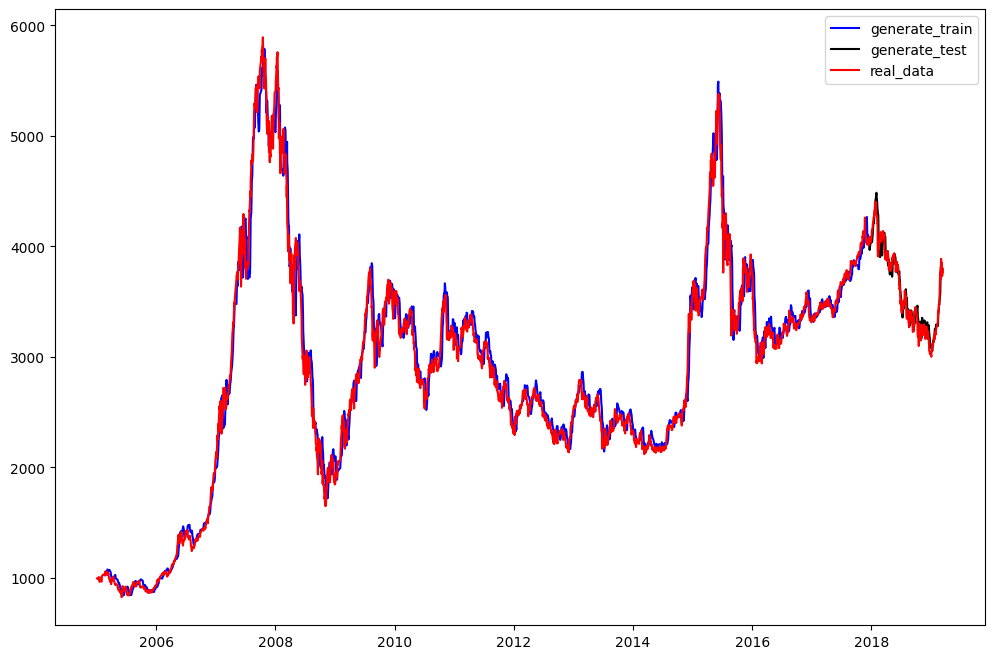

In [17]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series_test1) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series_test1 = (all_series_test1 - train_mean) / train_std
all_series_test1 = torch.Tensor(all_series_test1)

# len(all_series_test1)  # 3448

for i in range(DAYS_BEFORE, len(all_series_test1) - DAYS_PRED, DAYS_PRED):
    x = all_series_test1[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = torch.squeeze(rnn(x))
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
generate_data_train = np.concatenate(generate_data_train, axis=0)
generate_data_test  = np.concatenate(generate_data_test, axis=0)

# print(len(generate_data_train))   # 3122
# print(len(generate_data_test))    # 294

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: len(generate_data_train) + DAYS_BEFORE], generate_data_train, 'b', label='generate_train')
plt.plot(df_index[TRAIN_END:len(generate_data_test) + TRAIN_END], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_test1.clone().numpy() * train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()